In [1]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import MJO_E3SM_util as mjo
import pickle 

%load_ext autoreload
%autoreload 2

In [2]:
fn = '/global/cfs/cdirs/m4736/fme-output/28802636/autoregressive_predictions.nc'
ds = xr.open_dataset(fn)
ds = ds.isel(time=slice(0,365))

In [3]:
# change the time coordinate to be valid time
ds['time'] = ds['valid_time'][0,:]

In [4]:
def get_variables(var_name, ds, source_ind = 'prediction'):
    variables = []
    for i in range(8):
        data = ds[var_name+'_'+str(i)].sel(source=source_ind).squeeze()
        variables.append(data)

    lev = np.arange(len(variables))
    x = xr.concat(variables, dim='lev')
    x = x.assign_coords(lev=lev)
    x = x.transpose('time', 'lev', 'lat', 'lon')

    return x

In [6]:
T = get_variables('T', ds)
Z3 = get_variables('Z3', ds)
QLV = get_variables('QLV', ds)
DDSE_convection = get_variables('DDSE_convection', ds)
DQLV_CRM_ALT = get_variables('DQLV_CRM_ALT', ds)
DDSE_QRS = get_variables('DDSE_QRS', ds)
DDSE_QRL = get_variables('DDSE_QRL', ds)
DDSE_PBL = get_variables('DDSE_PBL', ds)
DQLV_PBL = get_variables('DQLV_PBL', ds)
DDSE_DYN = get_variables('DDSE_DYN', ds)
DQLV_DYN = get_variables('DQLV_DYN', ds)
FLNT = ds['FLNT'].sel(source='prediction').squeeze()

# convert them into a netcdf file with each name the same
ds = xr.Dataset({'FLNT': FLNT, 'T': T, 'Z3': Z3, 'QLV': QLV, 'DDSE_convection': DDSE_convection, 'DQLV_CRM_ALT': DQLV_CRM_ALT, 'DDSE_QRS': DDSE_QRS, 'DDSE_QRL': DDSE_QRL, 'DDSE_PBL': DDSE_PBL, 'DQLV_PBL': DQLV_PBL, 'DDSE_DYN': DDSE_DYN, 'DQLV_DYN': DQLV_DYN})
ds.to_netcdf('/global/cfs/cdirs/m4736/budget_analysis/control/model_output_prediction.nc')


In [7]:
mse_budget = mjo.get_local_MSE_budget_sep(ds, lat_lim=50)  # [time, lev, lat, lon]

get local MSE
get local MSE tendency
get local MSE source: CRM_ALT
get local MSE source: PBL
get local MSE source: QR
get local MSE source: DYN


In [8]:
# Write to a JSON file MJO_E3SM/regridded_data/analysis/local_MSE_budget
with open('/global/cfs/cdirs/m4736/budget_analysis/control/local_MSE_budget_control_prediction.json', 'wb') as file:
    pickle.dump(mse_budget, file)

print('budget saved')

budget saved


In [9]:
# average the OLR over 10S-10N
lat_lim = 10 
olr = ds['FLNT'].sel(lat=slice(-lat_lim,lat_lim))
olravg = olr.mean(dim='lat') # average over 10S-10N

# filter the olr data (k=1-9, f=0.01-0.05)
# olravg[time, lon]
olrflt = mjo.get_MJO_signal(olravg, d=1, kmin=1, kmax=9, flow=0.01, fhig=0.05)
# get the location of the miminum OLR
olrmin = olrflt.argmin(dim='lon')
print('olrmin calculated')


olrmin calculated


In [10]:
comp_fixed = mjo.get_local_MSE_budget_composite(mse_budget, olrmin)



dse
qlv
dtdse
dtqlv
crm_dse
crm_qlv
pbl_dse
pbl_qlv
qr
dyn_dse
dyn_qlv


In [12]:
# Write to a JSON file MJO_E3SM/regridded_data/analysis/local_MSE_budget
with open('/global/cfs/cdirs/m4736/budget_analysis/control/local_MSE_budget_composite_control_prediction.json', 'wb') as file:
    pickle.dump(comp_fixed, file)


In [13]:
ds_p = xr.open_dataset('/global/cfs/cdirs/m4736/budget_analysis/control/pressure.nc')

In [14]:
import numpy as np 
import xarray as xr 
import MJO_E3SM_util as mjo
import pandas as pd 
import matplotlib.pyplot as plt 
import pickle

def get_comp_4(comp, lat_lim=10):
    comp5 = {}
    comp5['mse'] = comp['dse'].sel(lat=slice(-lat_lim, lat_lim)).load() + comp['qlv'].sel(lat=slice(-lat_lim, lat_lim)).load()
    comp5['tendency'] = comp['dtdse'].sel(lat=slice(-lat_lim, lat_lim)).load() + comp['dtqlv'].sel(lat=slice(-lat_lim, lat_lim)).load()
    comp5['crmpbl'] = comp['crm_dse'].sel(lat=slice(-lat_lim, lat_lim)).load() + comp['crm_qlv'].sel(lat=slice(-lat_lim, lat_lim)).load() + comp['pbl_dse'].sel(lat=slice(-lat_lim, lat_lim)).load() + comp['pbl_qlv'].sel(lat=slice(-lat_lim, lat_lim)).load()
    comp5['dyn'] = comp['dyn_dse'].sel(lat=slice(-lat_lim, lat_lim)).load() + comp['dyn_qlv'].sel(lat=slice(-lat_lim, lat_lim)).load()
    comp5['qr'] = comp['qr'].sel(lat=slice(-lat_lim, lat_lim)).load()

    return comp5

def get_comp_5_new(comp, lat_lim=10):
    comp8 = {}
    comp8['mse'] = comp['dse'].sel(lat=slice(-lat_lim, lat_lim)).load() + comp['qlv'].sel(lat=slice(-lat_lim, lat_lim)).load()
    comp8['tendency'] = comp['dtdse'].sel(lat=slice(-lat_lim, lat_lim)).load() + comp['dtqlv'].sel(lat=slice(-lat_lim, lat_lim)).load()
    comp8['tendency_d'] = comp['dtdse'].sel(lat=slice(-lat_lim, lat_lim)).load() 
    comp8['tendency_m'] = comp['dtqlv'].sel(lat=slice(-lat_lim, lat_lim)).load()
    comp8['crmpbl_d'] = comp['crm_dse'].sel(lat=slice(-lat_lim, lat_lim)).load() + comp['pbl_dse'].sel(lat=slice(-lat_lim, lat_lim)).load() 
    comp8['crmpbl_m'] = comp['crm_qlv'].sel(lat=slice(-lat_lim, lat_lim)).load() + comp['pbl_qlv'].sel(lat=slice(-lat_lim, lat_lim)).load()
    comp8['dyn_d'] = comp['dyn_dse'].sel(lat=slice(-lat_lim, lat_lim)).load()
    comp8['dyn_m'] = comp['dyn_qlv'].sel(lat=slice(-lat_lim, lat_lim)).load()
    comp8['qr'] = comp['qr'].sel(lat=slice(-lat_lim, lat_lim)).load()

    return comp8


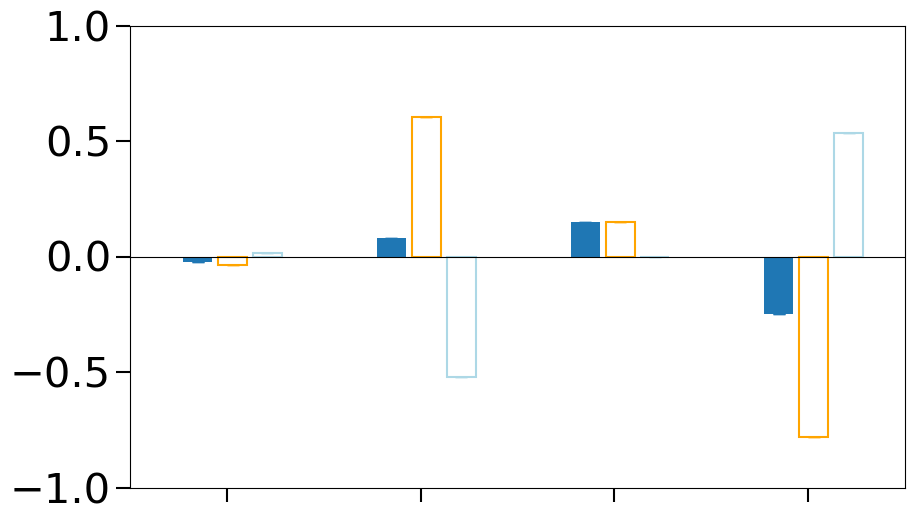

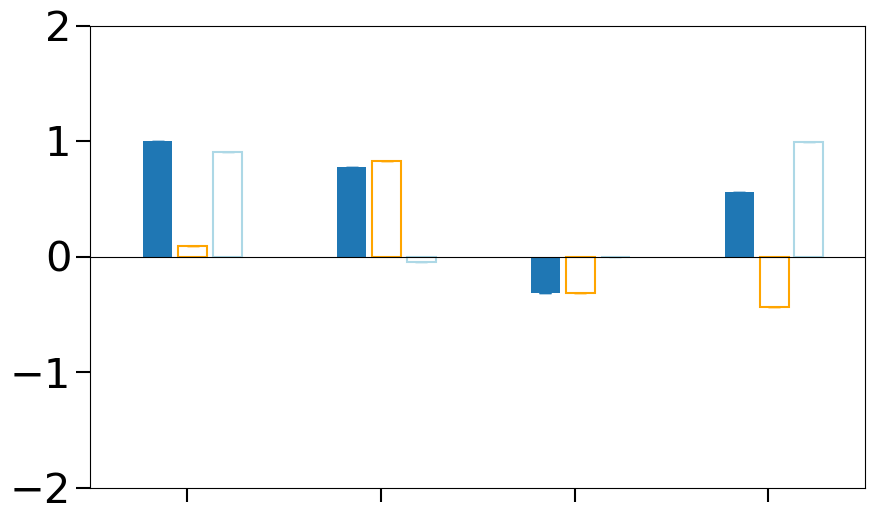

In [16]:
for case_dir in ['control',]:


    develop_uncertainty = {}
    develop_uncertainty['Tendency'] = []
    develop_uncertainty['CRMPBL'] = []
    develop_uncertainty['Radiation'] = []
    develop_uncertainty['Dynamics'] = []

    for lat_lim in [10,]:
        for kmax in [9,]:
            for Tlow in [100, ]:
                for Thig in [20,]:
                    
                    comp = get_comp_4(comp_fixed)

                    local_budget_develop = {}

                    p = ds_p['phalf'].sel(lat=slice(-lat_lim, lat_lim)).mean(['lat', 'lon']).load()  # dataarray
                    dp = np.zeros(len(p))
                    dp = p[1:].values - p[:-1].values

                    dp = xr.DataArray(dp, dims='lev', coords={'lev': np.arange(8)})

                    for key in comp.keys():
                        tmp = (comp['mse'] * comp[key]).mean(dim=['lon', 'lat'])
                        local_budget_develop[key] = (tmp * dp / 9.8 ).sum(dim='lev').values
            
                    norm = local_budget_develop['mse'] 
                    develop_uncertainty['Tendency'].append(local_budget_develop['tendency'] / norm)
                    develop_uncertainty['CRMPBL'].append(local_budget_develop['crmpbl'] / norm)
                    develop_uncertainty['Radiation'].append(local_budget_develop['qr'] / norm) 
                    develop_uncertainty['Dynamics'].append(local_budget_develop['dyn'] / norm)

                    del comp

    tend = develop_uncertainty['Tendency']
    convd = develop_uncertainty['CRMPBL'] 
    rad = develop_uncertainty['Radiation']
    dynd = develop_uncertainty['Dynamics']

    tend_av = np.mean(tend)
    convd_av = np.mean(convd)
    rad_av = np.mean(rad)
    dynd_av = np.mean(dynd)

    tend_std = np.std(tend)
    convd_std = np.std(convd)
    rad_std = np.std(rad)
    dynd_std = np.std(dynd)

    propagation_mse = [tend_av, convd_av, rad_av, dynd_av]
    propagation_mse_std = [tend_std, convd_std, rad_std, dynd_std]  

    x4 = ['Tendency', 'CRM+PBL', 'Radiation', 'Dynamics']
    x_axis = np.arange(len(x4))

    develop_uncertainty = {}
    develop_uncertainty['Tendency_dry'] = []
    develop_uncertainty['Tendency_moist'] = []
    develop_uncertainty['CRMPBL_dry'] = []
    develop_uncertainty['CRMPBL_moist'] = []
    develop_uncertainty['Radiation'] = []
    develop_uncertainty['Dynamics_dry'] = []
    develop_uncertainty['Dynamics_moist'] = []

    for lat_lim in [10,]:
        for kmax in [9, ]:
            for Tlow in [100, ]:
                for Thig in [20, ]:
                    comp = get_comp_5_new(comp_fixed)

                    local_budget_develop = {}

                    for key in comp.keys():
                        tmp = (comp['mse'] * comp[key]).mean(dim=['lon', 'lat'])
                        local_budget_develop[key] = (tmp * dp / 9.8).sum(dim='lev').values
            
                    norm = local_budget_develop['mse'] 
                    develop_uncertainty['Tendency_dry'].append(local_budget_develop['tendency_d'] / norm)
                    develop_uncertainty['Tendency_moist'].append(local_budget_develop['tendency_m'] / norm)
                    develop_uncertainty['CRMPBL_dry'].append(local_budget_develop['crmpbl_d'] / norm)
                    develop_uncertainty['CRMPBL_moist'].append(local_budget_develop['crmpbl_m'] / norm)
                    develop_uncertainty['Radiation'].append(local_budget_develop['qr'] / norm) 
                    develop_uncertainty['Dynamics_dry'].append(local_budget_develop['dyn_d'] / norm)
                    develop_uncertainty['Dynamics_moist'].append(local_budget_develop['dyn_m'] / norm)

                    del comp

    tendd = develop_uncertainty['Tendency_dry']
    tendm = develop_uncertainty['Tendency_moist']
    convd = develop_uncertainty['CRMPBL_dry'] 
    convm = develop_uncertainty['CRMPBL_moist'] 
    rad = develop_uncertainty['Radiation']
    dynd = develop_uncertainty['Dynamics_dry']
    dynm = develop_uncertainty['Dynamics_moist']

    tendd_av = np.mean(tendd)
    tendm_av = np.mean(tendm)
    convd_av = np.mean(convd)
    convm_av = np.mean(convm)
    rad_av = np.mean(rad)
    dynd_av = np.mean(dynd)
    dynm_av = np.mean(dynm)

    tendd_std = np.std(tendd)
    tendm_std = np.std(tendm)
    convd_std = np.std(convd)
    convm_std = np.std(convm)
    rad_std = np.std(rad)
    dynd_std = np.std(dynd)
    dynm_std = np.std(dynm)

    propagation_dse = [tendd_av, convd_av, rad_av, dynd_av]
    propagation_dse_std = [tendd_std, convd_std, rad_std, dynd_std]

    propagation_qlv = [tendm_av, convm_av, 0, dynm_av]
    propagation_qlv_std = [tendm_std, convm_std, 0, dynm_std]

    # Define the width of each bar and the spacing between bar groups
    bar_width = 0.15
    spacing = 0.03  # Space between bars within a group
    group_width = (bar_width + spacing) * 2  # Width of each group of bars

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.rcParams.update({'font.size': 30})

    # Adjust the position of each bar
    for i in range(len(x_axis)):
        ax.bar(x_axis[i] - group_width / 2 + spacing, propagation_mse[i], yerr=propagation_mse_std[i], capsize=4, ecolor='tab:blue', width=bar_width, color='tab:blue')
        ax.bar(x_axis[i] - group_width / 2 + bar_width + 2 * spacing, propagation_dse[i], yerr=propagation_dse_std[i], capsize=4, ecolor='orange', width=bar_width, color='white', edgecolor='orange', linewidth=1.5)
        ax.bar(x_axis[i] - group_width / 2 + 2 * bar_width + 3 * spacing, propagation_qlv[i], yerr=propagation_qlv_std[i], capsize=4, ecolor='lightblue', width=bar_width, color='white', edgecolor='lightblue', linewidth=1.5)

    ax.plot([-1,4],[0,0],'k-',linewidth=0.8)

    ax.set_xticks(x_axis, ['','','',''])
    # ax.set_ylabel("day" + r'$^{-1}$')
    ax.set_ylim([-1.0,1.0])
    ax.set_xlim([-0.5,3.5])
    # ax.set_yticks([-0.5,-0.5,0,0.5,1])
    ax.tick_params(axis='both', which='major', length=10, width=1.5)
    # plt.savefig('./plots/'+case_dir+'/VR_develop_4terms.pdf', bbox_inches='tight')

    develop_uncertainty = {}
    develop_uncertainty['Tendency'] = []
    develop_uncertainty['CRMPBL'] = []
    develop_uncertainty['Radiation'] = []
    develop_uncertainty['Dynamics'] = []

    for lat_lim in [10,]:
        for kmax in [9,]:
            for Tlow in [100, ]:
                for Thig in [20,]:
                    
                    comp = get_comp_4(comp_fixed)

                    local_budget_develop = {}

                    p = ds_p['phalf'].sel(lat=slice(-lat_lim, lat_lim)).mean(['lat', 'lon']).load()  # dataarray
                    dp = np.zeros(len(p))
                    dp = p[1:].values - p[:-1].values

                    dp = xr.DataArray(dp, dims='lev', coords={'lev': np.arange(8)})

                    for key in comp.keys():
                        tmp = (comp['tendency'] * comp[key]).mean(dim=['lon', 'lat'])
                        local_budget_develop[key] = (tmp * dp / 9.8 ).sum(dim='lev').values
            
                    norm = local_budget_develop['tendency'] 
                    develop_uncertainty['Tendency'].append(local_budget_develop['tendency'] / norm)
                    develop_uncertainty['CRMPBL'].append(local_budget_develop['crmpbl'] / norm)
                    develop_uncertainty['Radiation'].append(local_budget_develop['qr'] / norm) 
                    develop_uncertainty['Dynamics'].append(local_budget_develop['dyn'] / norm)

                    del comp

    tend = develop_uncertainty['Tendency']
    convd = develop_uncertainty['CRMPBL'] 
    rad = develop_uncertainty['Radiation']
    dynd = develop_uncertainty['Dynamics']

    tend_av = np.mean(tend)
    convd_av = np.mean(convd)
    rad_av = np.mean(rad)
    dynd_av = np.mean(dynd)

    tend_std = np.std(tend)
    convd_std = np.std(convd)
    rad_std = np.std(rad)
    dynd_std = np.std(dynd)

    propagation_mse = [tend_av, convd_av, rad_av, dynd_av]
    propagation_mse_std = [tend_std, convd_std, rad_std, dynd_std]  

    x4 = ['Tendency', 'CRM+PBL', 'Radiation', 'Dynamics']
    x_axis = np.arange(len(x4))

    develop_uncertainty = {}
    develop_uncertainty['Tendency_dry'] = []
    develop_uncertainty['Tendency_moist'] = []
    develop_uncertainty['CRMPBL_dry'] = []
    develop_uncertainty['CRMPBL_moist'] = []
    develop_uncertainty['Radiation'] = []
    develop_uncertainty['Dynamics_dry'] = []
    develop_uncertainty['Dynamics_moist'] = []

    for lat_lim in [10,]:
        for kmax in [9, ]:
            for Tlow in [100, ]:
                for Thig in [20, ]:
                    comp = get_comp_5_new(comp_fixed)

                    local_budget_develop = {}

                    for key in comp.keys():
                        tmp = (comp['tendency'] * comp[key]).mean(dim=['lon', 'lat'])
                        local_budget_develop[key] = (tmp * dp / 9.8).sum(dim='lev').values
            
                    norm = local_budget_develop['tendency'] 
                    develop_uncertainty['Tendency_dry'].append(local_budget_develop['tendency_d'] / norm)
                    develop_uncertainty['Tendency_moist'].append(local_budget_develop['tendency_m'] / norm)
                    develop_uncertainty['CRMPBL_dry'].append(local_budget_develop['crmpbl_d'] / norm)
                    develop_uncertainty['CRMPBL_moist'].append(local_budget_develop['crmpbl_m'] / norm)
                    develop_uncertainty['Radiation'].append(local_budget_develop['qr'] / norm) 
                    develop_uncertainty['Dynamics_dry'].append(local_budget_develop['dyn_d'] / norm)
                    develop_uncertainty['Dynamics_moist'].append(local_budget_develop['dyn_m'] / norm)

                    del comp

    tendd = develop_uncertainty['Tendency_dry']
    tendm = develop_uncertainty['Tendency_moist']
    convd = develop_uncertainty['CRMPBL_dry'] 
    convm = develop_uncertainty['CRMPBL_moist'] 
    rad = develop_uncertainty['Radiation']
    dynd = develop_uncertainty['Dynamics_dry']
    dynm = develop_uncertainty['Dynamics_moist']

    tendd_av = np.mean(tendd)
    tendm_av = np.mean(tendm)
    convd_av = np.mean(convd)
    convm_av = np.mean(convm)
    rad_av = np.mean(rad)
    dynd_av = np.mean(dynd)
    dynm_av = np.mean(dynm)

    tendd_std = np.std(tendd)
    tendm_std = np.std(tendm)
    convd_std = np.std(convd)
    convm_std = np.std(convm)
    rad_std = np.std(rad)
    dynd_std = np.std(dynd)
    dynm_std = np.std(dynm)

    propagation_dse = [tendd_av, convd_av, rad_av, dynd_av]
    propagation_dse_std = [tendd_std, convd_std, rad_std, dynd_std]

    propagation_qlv = [tendm_av, convm_av, 0, dynm_av]
    propagation_qlv_std = [tendm_std, convm_std, 0, dynm_std]

    # Define the width of each bar and the spacing between bar groups
    bar_width = 0.15
    spacing = 0.03  # Space between bars within a group
    group_width = (bar_width + spacing) * 2  # Width of each group of bars

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.rcParams.update({'font.size': 30})

    # Adjust the position of each bar
    for i in range(len(x_axis)):
        ax.bar(x_axis[i] - group_width / 2 + spacing, propagation_mse[i], yerr=propagation_mse_std[i], capsize=4, ecolor='tab:blue', width=bar_width, color='tab:blue')
        ax.bar(x_axis[i] - group_width / 2 + bar_width + 2 * spacing, propagation_dse[i], yerr=propagation_dse_std[i], capsize=4, ecolor='orange', width=bar_width, color='white', edgecolor='orange', linewidth=1.5)
        ax.bar(x_axis[i] - group_width / 2 + 2 * bar_width + 3 * spacing, propagation_qlv[i], yerr=propagation_qlv_std[i], capsize=4, ecolor='lightblue', width=bar_width, color='white', edgecolor='lightblue', linewidth=1.5)

    ax.plot([-1,4],[0,0],'k-',linewidth=0.8)
    ax.tick_params(axis='both', which='major', length=10, width=1.5)
    ax.set_xticks(x_axis, ['','','',''])
    # ax.set_ylabel("day" + r'$^{-1}$')
    # ax.set_ylim([-1.0,1.6])
    ax.set_ylim([-2.0,2.0])
    ax.set_xlim([-0.5,3.5])
    # ax.set_yticks([-1,-0.5,0,0.5,1,1.5])
    # plt.savefig('./plots/'+case_dir+'/VR_propagation_4terms.pdf', bbox_inches='tight')

